# 1. Import modules 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# 2. Read prices from CSV file

In [2]:
# Reading the commodity spot data between 2012 and 2020
spot = pd.read_csv('com_spot_2012_2019.csv',index_col='Date')
# Converting index to datetime format from text
spot.index = pd.to_datetime(spot.index)

In [3]:
# Reading the commodity futures data between 2012 and 2020
future = pd.read_csv('com_futures_2012_2019.csv',index_col='Date')
# Converting index to datetime format from text
future.index = pd.to_datetime(future.index)

# 3. Rank based on future spot ratio

In [4]:
# Calculate the ratio
future_spot_ratio = future/spot
# Rank each row which corresponds to each day
rank = future_spot_ratio.rank(axis=1)
# Total number of ranks
total_ranks = rank.shape[1]
# Ranks for the last 5 business days of 2019
rank.tail(5)

,soyabean oil,corn,cocoa,crude oil,cotton,ethanol,feeder cattle,gold,copper,heating oil,...,natural gas,oats,palladium,platinum,rbob,rough rice,soybean,sugar,silver,soyameal
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-26,9.0,15.5,15.5,10.0,15.5,2.0,20.0,24.0,21.0,23.0,...,25.0,15.5,11.0,7.0,4.0,5.0,8.0,15.5,22.0,6.0
2019-12-27,9.0,15.5,15.5,10.0,15.5,4.0,22.0,20.0,21.0,24.0,...,25.0,15.5,11.0,8.0,3.0,6.0,7.0,15.5,23.0,5.0
2019-12-29,8.0,14.5,14.5,10.0,14.5,4.0,22.0,21.0,19.0,24.0,...,25.0,14.5,9.0,20.0,3.0,6.0,7.0,14.5,23.0,5.0
2019-12-30,8.0,15.5,15.5,20.0,15.5,4.0,22.0,21.0,10.0,24.0,...,25.0,15.5,11.0,9.0,3.0,5.0,7.0,15.5,23.0,6.0
2019-12-31,8.0,17.5,17.5,11.0,17.5,5.0,23.0,10.0,12.0,24.0,...,25.0,17.5,13.0,9.0,3.0,6.0,7.0,17.5,22.0,4.0


In [5]:
# Creata a new empty dataframe
ratio_rank = pd.DataFrame()
# Add the future spot ratio as a column
ratio_rank['fut_spot_ratio'] = future_spot_ratio.iloc[-1,:]
# Add the rank as a column
ratio_rank['rank'] = rank.iloc[-1,:]
ratio_rank.sort_values("rank")

,fut_spot_ratio,rank
wheat,0.869799,1.0
lumber,0.950962,2.0
rbob,0.972497,3.0
soyameal,0.984247,4.0
ethanol,0.987078,5.0
rough rice,0.988709,6.0
soybean,0.989507,7.0
soyabean oil,0.993662,8.0
platinum,0.994757,9.0
gold,0.997702,10.0


# 4. Plot future spot ratio

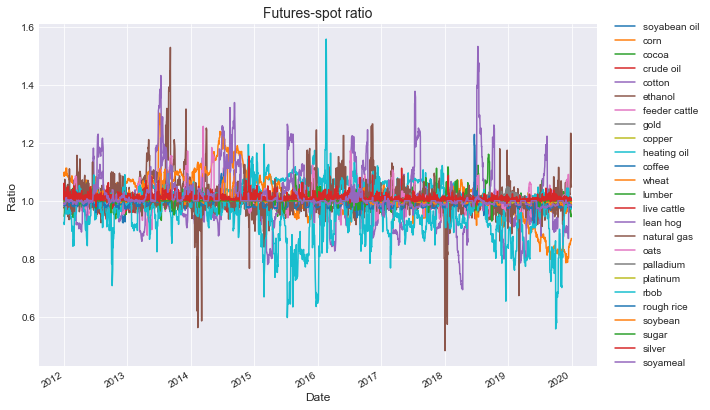

In [6]:
future_spot_ratio.plot(figsize=(10, 7))
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.title("Futures-spot ratio", fontsize=14)
# Define the labels for x-axis and y-axis
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ratio", fontsize=12)
plt.show()

# 5. Commodity spot correlation

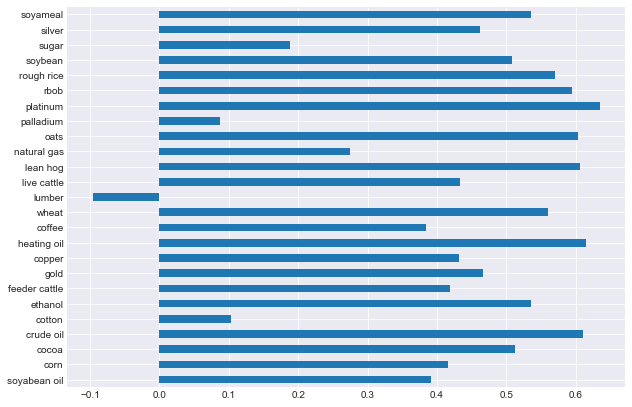

In [7]:
# Set figure size
plt.figure(figsize=(10, 7))
# Finding and plotting the correlation between equally weighted portfolio of commodity spot
# and each commodity spot price
spot.corrwith(spot.mean(axis=1)).plot(kind='barh')
plt.show()

# 6. Generate the trading signal

In [8]:
def signal(rank):
        # Go short on all ranks in the bottom two deciles
        signal = np.where(rank>total_ranks*8/10,-1,np.nan)
        # Go long on all ranks in the top two deciles
        signal = np.where(rank<total_ranks*2/10,+1,signal)
        return signal
signal = rank.apply(signal,axis=0)

# 7. Calculate returns 

In [9]:
holding_time = 10 # days
# Calculate futures returns for holding days and shift it back by number of holding days
holding_period_futures_returns = future.pct_change(holding_time).shift(-1*holding_time)
# Calculate futures returns between holding days. This is done by jumping number of holding days.
futures_returns = holding_period_futures_returns[::holding_time] * signal[::holding_time]

# 8. Calculate trading cost

In [10]:
# Trade financing cost
trading_signal = signal[::holding_time]
trading_signal = trading_signal.replace(np.nan,0)
# Trading cost applied when position changed.
cost = (0.001 * np.abs(trading_signal - trading_signal.shift(-1)))

# Applying cost to futures returns
futures_returns = futures_returns - cost

# 9. Evaluate the strategy

5.22


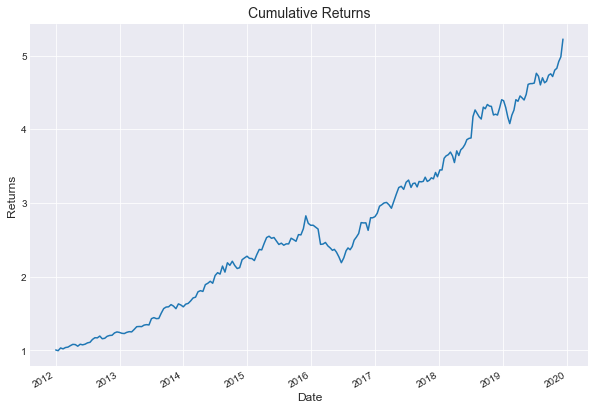

In [11]:
portf_ret = futures_returns.mean(axis=1)
print("%.2f" % (portf_ret+1).prod())
# Set figure size
plt.figure(figsize=(10, 7))
# Define the label for the title of the figure
plt.title("Cumulative Returns", fontsize=14)
# Define the labels for x-axis and y-axis
plt.xlabel("Date", fontsize=12)
plt.ylabel("Returns", fontsize=12)

(portf_ret+1).cumprod().plot()
plt.show()

The maximum drawdown is -22.49


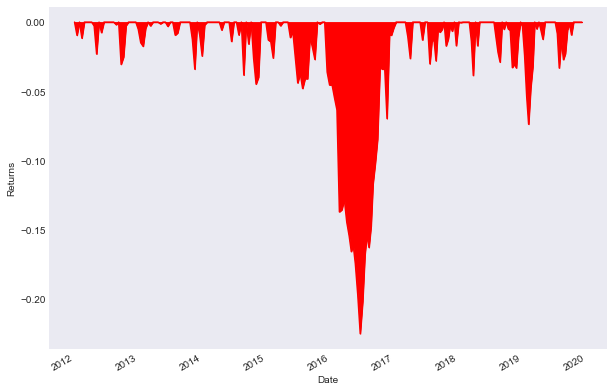

In [12]:
cum_rets = (portf_ret+1).cumprod()
running_max = np.maximum.accumulate(cum_rets.dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdowns
drawdown = ((cum_rets)/running_max - 1)
max_dd = drawdown.min()*100
print('The maximum drawdown is %.2f' % max_dd)
# Set figure size
plt.figure(figsize=(10, 7))
# Plot drawdowns
drawdown.plot(color='r',figsize=(10,7))
plt.ylabel('Returns')
plt.fill_between(drawdown.index, drawdown, color='red')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
plt.show()    

In [13]:
# Sharpe ratio
sharpe = (portf_ret.mean()/portf_ret.std())*(252/holding_time)**0.5
print("%.2f" % sharpe)

1.74
